# PCA AND CLUSTERING ASSIGNMENT 

#### Problem Statement :
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively.Our Objective is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most

We will follow the following steps in this analysis:
1. Read and Understand the data
2. Data Visualization
3. Data Preparation
4. PCA
5. Clustering - K-means and Hierarchical
6. Cluster Analysis to find the top 5 under-developed countries in need of aid.

## 1. Read and understand the data

In [399]:
#Importing all the required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

#libraries required for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#Libraries required to perform PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

#Libraries to check for hopkins statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# To perform KMeans clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [400]:
#Reading the dataset into a datafram
df=pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [401]:
#Checking the number of rows and columns in the dataframe
df.shape

(167, 10)

In [402]:
#Obtaining concise summary about the Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [403]:
#Getting metrics about the data
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [404]:
#We will check each column for any null values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

We can see that there are no null values in the dataframe.

In [405]:
#We will check to see if any rows are duplicated
sum(df.duplicated(subset = 'country'))

0



We can see that there are no duplicated rows.

In [406]:
#Checking the datatypes
df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

## 2. Data Visualisation

###  OUTLIER ANALYSIS - UNIVARIATE ANALYSIS

In [407]:
#Numerical features are extracted for further analysis
numerical_features= [f for f in df.columns if df.dtypes[f]!='object']

#Finding percentage of outliers in all numerical features
for col in numerical_features:
    q1,q3 =np.percentile(df[col],[25,75])
    IQR = q3-q1
    lowerbound = q1 -1.5*IQR
    upperbound = q3 +1.5*IQR
    outliers = df.loc[df[col]<lowerbound].shape[0] + df.loc[df[col]>upperbound].shape[0]
    outliers_ratio =round((outliers/len(df))*100,2)
    print("% of outliers in ",col,outliers_ratio)

% of outliers in  child_mort 2.4
% of outliers in  exports 2.99
% of outliers in  health 1.2
% of outliers in  imports 2.4
% of outliers in  income 4.79
% of outliers in  inflation 2.99
% of outliers in  life_expec 1.8
% of outliers in  total_fer 0.6
% of outliers in  gdpp 14.97


#### We can see that the percentage of outliers in the dataset is low except for the GDPP column. We will further visualise this data using box plots and take a call on whether we should treat the outliers

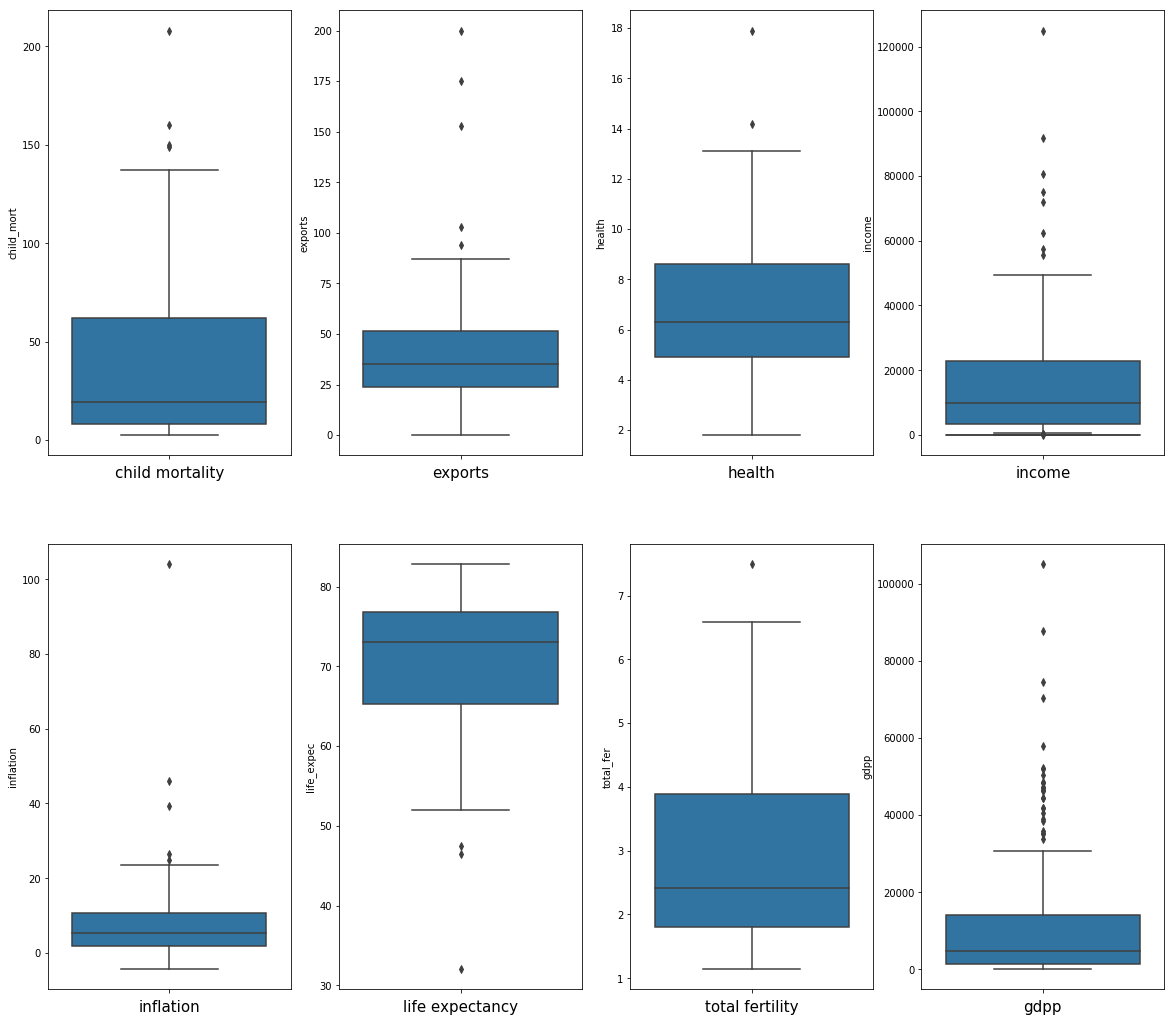

In [408]:
#Plotting Graphs to visualise the outliers

plt.figure(figsize=(20, 18))

plt.subplot(2,4,1)
sns.boxplot( y = 'child_mort', data =df)
plt.xlabel("child mortality",fontsize=15)


plt.subplot(2,4,2)
sns.boxplot( y = 'exports', data =df)
plt.xlabel("exports",fontsize=15)


plt.subplot(2,4,3)
sns.boxplot( y = 'health', data =df)
plt.xlabel("health",fontsize=15)

plt.subplot(2,4,4)
sns.boxplot( y = 'imports', data =df)
plt.xlabel("imports",fontsize=15)

plt.subplot(2,4,4)
sns.boxplot( y = 'income', data =df)
plt.xlabel("income",fontsize=15)

plt.subplot(2,4,5)
sns.boxplot( y = 'inflation', data =df)
plt.xlabel("inflation",fontsize=15)

plt.subplot(2,4,6)
sns.boxplot( y = 'life_expec', data =df)
plt.xlabel("life expectancy",fontsize=15)


plt.subplot(2,4,7)
sns.boxplot( y = 'total_fer', data =df)
plt.xlabel("total fertility",fontsize=15)

plt.subplot(2,4,8)
sns.boxplot( y = 'gdpp', data =df)
plt.xlabel("gdpp",fontsize=15)


plt.show()

#### Outlier Treatment

Text(0.5, 0, 'gdpp')

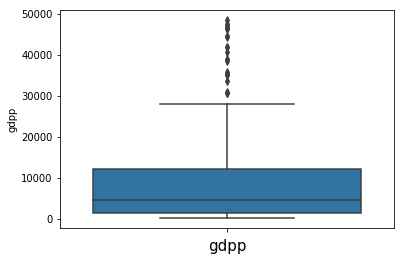

In [409]:
#Removing outliers above 95 percentile in the "gdpp" column

q = df["gdpp"].quantile(0.95) #(data points that are more than 95 percentile)
df=df[df["gdpp"] <=q]

#Plotting the box plot for the "gdpp" column again to see the spread of data after removal of outliers.
sns.boxplot( y = 'gdpp', data =df)
plt.xlabel("gdpp",fontsize=15)

#### Removing the outliers above 95th percentile in the gdpp column will remove countries which are already well-developed. Hence, this will not have a negative affect on the analysis as we have to find the under-developed countries. We have kept all the records lower than it so that in the process of outlier removal, we dont miss out on those countries which lie at very low percentiles as these might be the countries which are in dire need of help.

Text(0.5, 0, 'income')

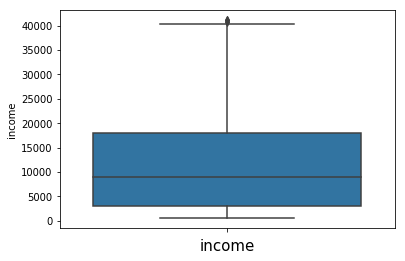

In [410]:
#Removing outliers above 95 percentile in the "income" column

q = df["income"].quantile(0.95) #(data points that are more than 95 percentile)
df=df[df["income"] <=q]

#Plotting the box plot for the "income" column again to see the spread of data after removal of outliers.
sns.boxplot( y = 'income', data =df)
plt.xlabel("income",fontsize=15)

#### Similarly we remove outliers above the 95th percentile in the "income" column.

In [411]:
#Checking the shape of the dataframe again after outlier removal
df.shape

(150, 10)

<Figure size 1296x720 with 0 Axes>

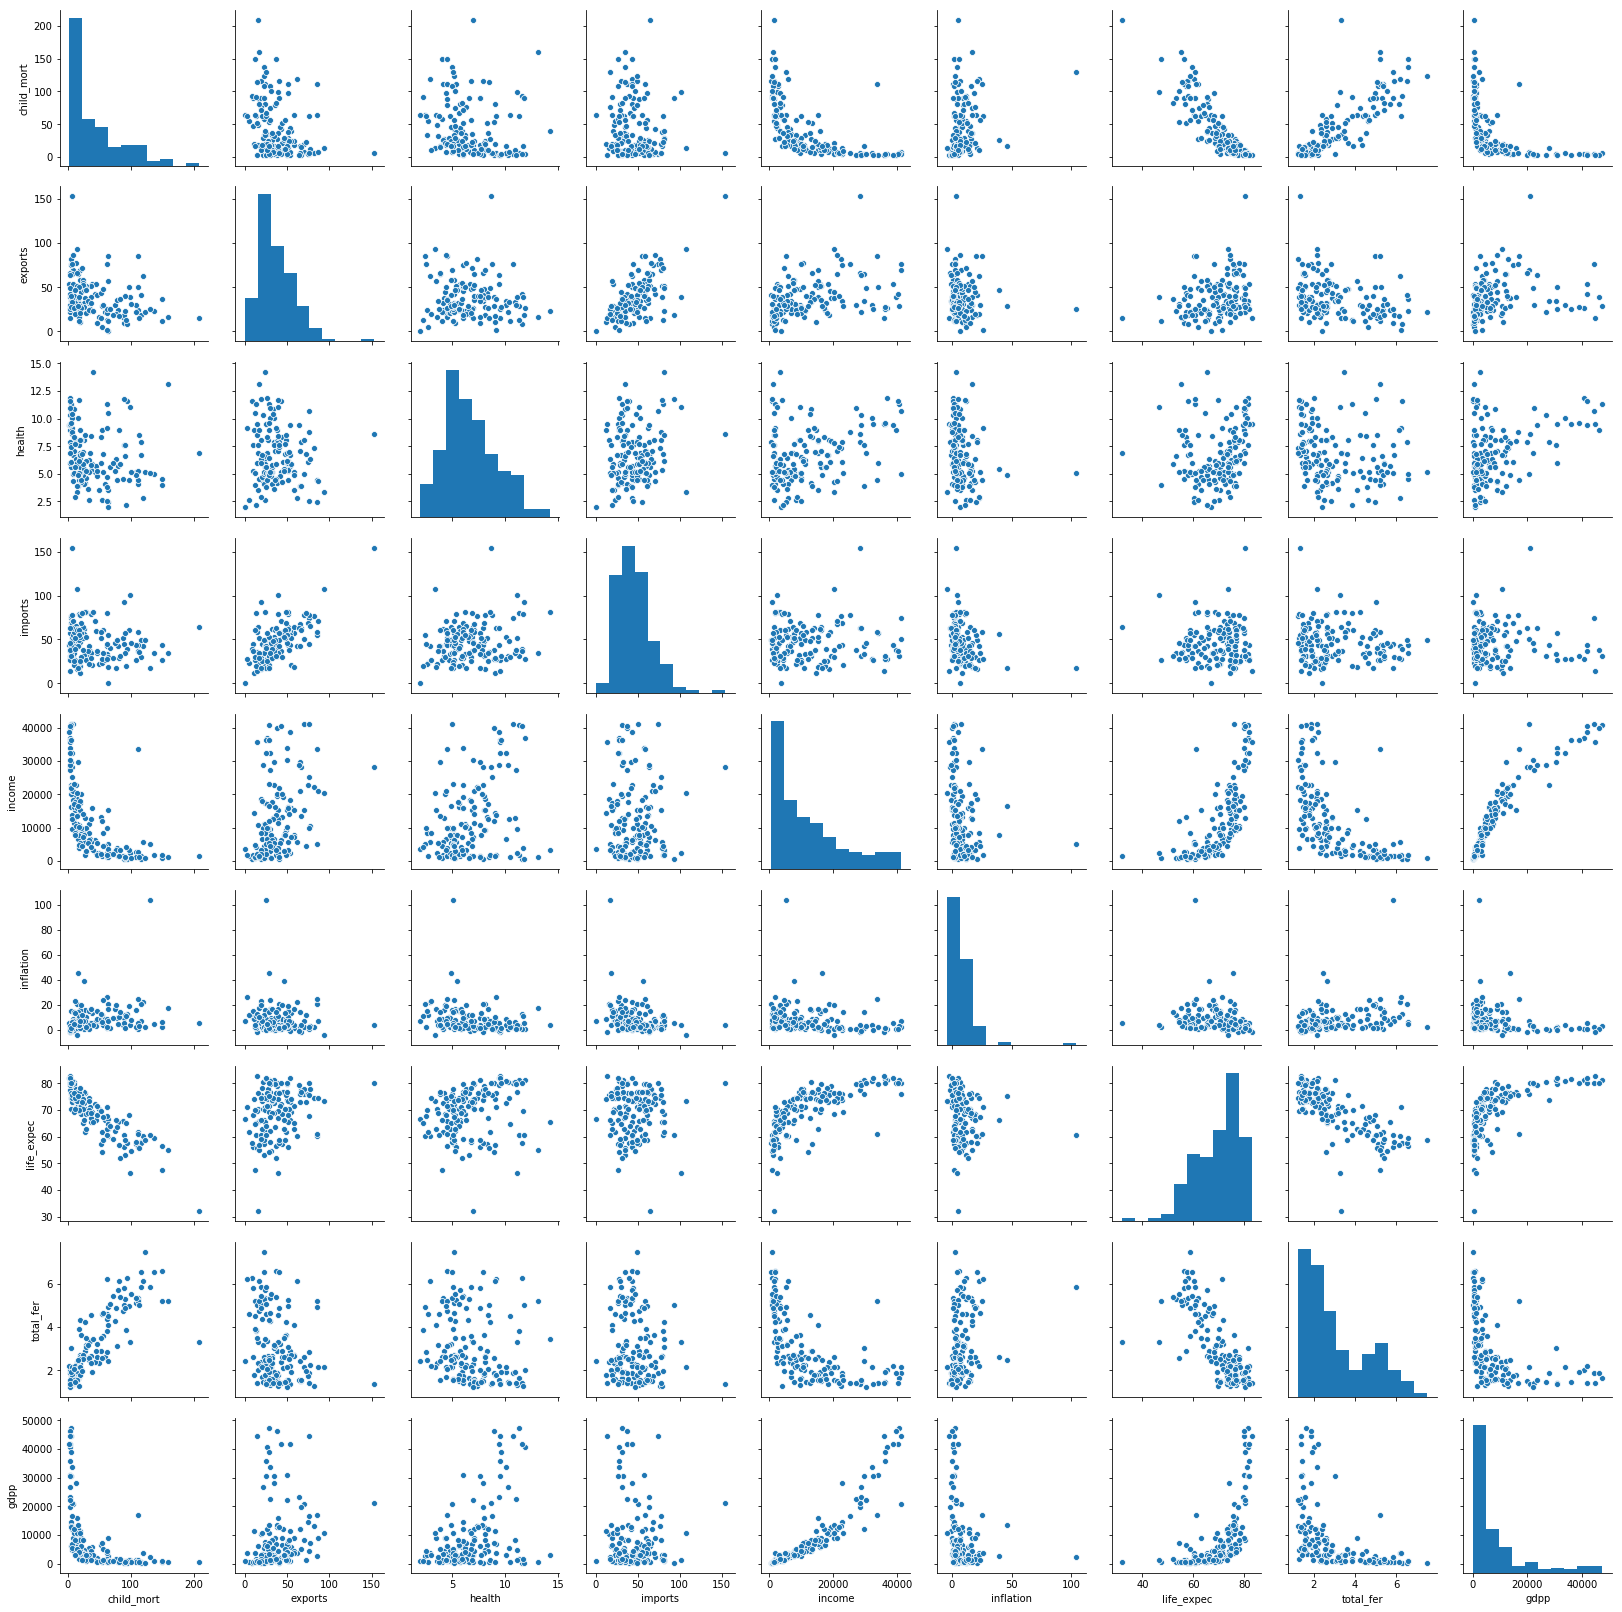

In [412]:
#We can check the correlation between the data using pairplot. This will help us decide if PCA is justified.
plt.figure(figsize=(18,10))
sns.pairplot(df)
plt.show()

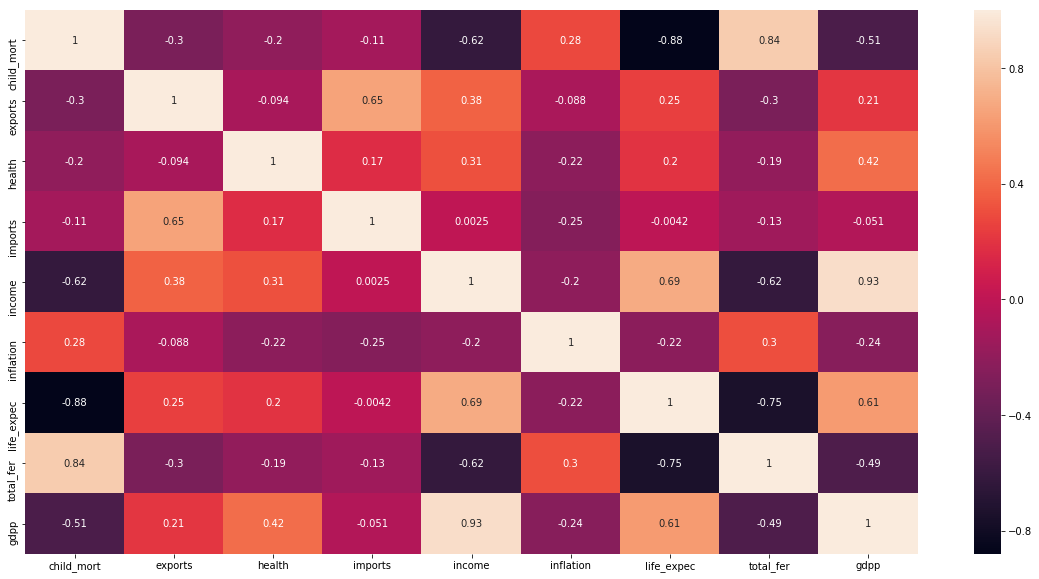

In [413]:
#Using heatmap to see the correlation between the data.
plt.figure(figsize = (20,10))        
sns.heatmap(df.corr(),annot = True)

#### We can see that that the variables are quite highly correlated, for eg. Income is highly correlated to total_fer and child_mort and so on. Thus, we can proceed with PCA to deal with this multicollinearity.

## 3. Data Preparation

In [414]:
#Converting exports,imports and health spending percentages to absolute values.
df['exports'] = round((df['exports']*df['gdpp']/100),2)
df['imports'] = round((df['imports']*df['gdpp']/100),2)
df['health'] = round((df['health']*df['gdpp']/100),2)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [415]:
#To proceed with PCA and clustering, we will drop the "country" column and keep only the numerical columns.
df_1=df.drop(['country'],axis=1)
df_1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [416]:
#We can now scale the data using Standardization since all the variables are in different order of magnitude.
standard_scaler = StandardScaler()
df_1 = standard_scaler.fit_transform(df_1)
df_1

array([[ 1.18228592, -0.65404363, -0.57688163, ..., -1.52261333,
         1.78511717, -0.71419292],
       [-0.61787635, -0.45913834, -0.37509091, ...,  0.77295582,
        -0.91339602, -0.39686064],
       [-0.35616798, -0.35766383, -0.44824205, ...,  0.79579731,
        -0.11096045, -0.36366501],
       ...,
       [-0.45400288, -0.49526171, -0.53430538, ...,  0.40749208,
        -0.71925838, -0.64627645],
       [ 0.35313509, -0.59365321, -0.55371829, ..., -0.23206948,
         1.04092288, -0.64627645],
       [ 1.00862897, -0.56732964, -0.53752896, ..., -2.0022845 ,
         1.51332447, -0.63281876]])

## 4. PCA 

In [417]:
pca = PCA(svd_solver='randomized', random_state=42)

In [418]:
#Applying PCA
pca.fit(df_1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [419]:
pca.components_

array([[-3.10209857e-01,  3.56656037e-01,  3.60030919e-01,
         3.62761210e-01,  3.89533189e-01, -1.39995301e-01,
         3.31300174e-01, -3.00137773e-01,  3.79698671e-01],
       [ 5.05795588e-01,  3.19290418e-01,  2.70111075e-01,
         2.80306452e-01,  1.23299357e-01,  2.07031954e-01,
        -3.76485380e-01,  4.79557267e-01,  2.46802304e-01],
       [-1.38845416e-01, -1.73714424e-02, -3.05139236e-02,
        -6.48083234e-02,  1.00588774e-01,  9.58429531e-01,
         2.03248718e-01, -7.19719111e-02,  9.67992605e-03],
       [-5.71761402e-02,  5.11635191e-01, -5.26465524e-01,
         5.02152459e-01, -1.16256648e-01,  4.61590114e-02,
        -1.08412597e-01, -1.49223488e-01, -3.94930471e-01],
       [ 1.99432848e-01, -7.84625053e-02,  5.65414623e-02,
        -9.48384385e-02,  1.81315658e-01,  7.72373750e-02,
        -6.07179438e-01, -7.27574024e-01,  7.07608560e-02],
       [ 2.03715540e-01,  2.73041010e-02, -4.71878261e-01,
        -2.56942161e-01,  7.91135376e-01, -1.016424

In [420]:
#Checking the variance ratios
pca.explained_variance_ratio_

array([0.6507419 , 0.15453536, 0.09945636, 0.04484338, 0.0268795 ,
       0.01131465, 0.00984261, 0.00135513, 0.00103111])

<BarContainer object of 9 artists>

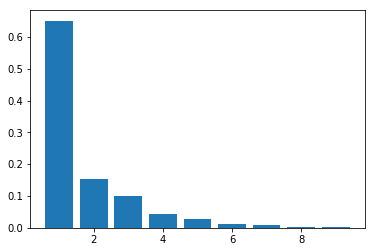

In [421]:
#Plotting a barplot to see the amount of variance explained by the PCAs
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

#### We can see that the maximum variance of around 65% is explained by the first principal component.

In [422]:
#Calculating the cumulative variance explained by the Principal Components
var_cumu = np.cumsum(pca.explained_variance_ratio_)

#### Making Scree Plot

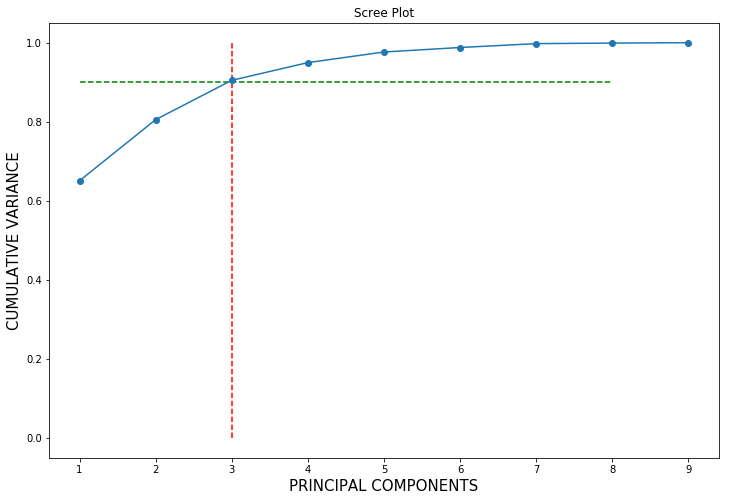

In [423]:
#Plotting a scree plot to decide on the number of principal components to be selected for further analysis
fig = plt.figure(figsize=[12,8])
plt.plot(range(1,len(var_cumu)+1),var_cumu,marker="o")
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=8, xmin=1, colors="g", linestyles="--")
plt.xlabel("PRINCIPAL COMPONENTS",fontsize=15)
plt.ylabel("CUMULATIVE VARIANCE",fontsize=15)
plt.title("Scree Plot")
plt.show()

#### The first three Principal Components explain about 90% of the variance in the data. Hence, we will choose 3 components to proceed with clustering. We can see that the fourth Principal component explains about 4% variance but not much as the first three Principal Components which explain  around 65%, 15% and 10% respectively. Hence, we take the decision to move forward with the first three principal components.

In [424]:
#Let's try and check the first three components now
colnames = list(df.drop("country",axis=1).columns)
pcs_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
pcs_df


,Feature,PC1,PC2,PC3
0,child_mort,-0.310210,0.505796,-0.138845
1,exports,0.356656,0.319290,-0.017371
2,health,0.360031,0.270111,-0.030514
3,imports,0.362761,0.280306,-0.064808
4,income,0.389533,0.123299,0.100589
5,inflation,-0.139995,0.207032,0.958430
6,life_expec,0.331300,-0.376485,0.203249
7,total_fer,-0.300138,0.479557,-0.071972
8,gdpp,0.379699,0.246802,0.009680


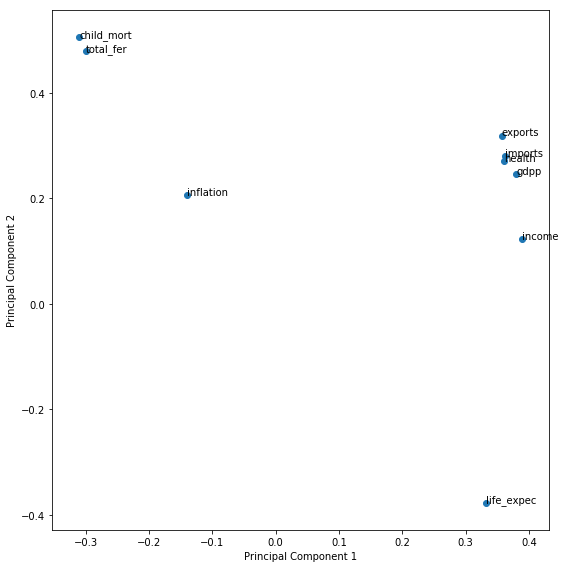

In [425]:
# We will plot a scatterplot to visualize the first two Principal Components
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### From above plot it can be observed that: 
1. First component is in the direction where the 'life_expec' variable is heavy.
2. Both components are in the direction where the 'import','export','health','gdpp' and 'income' variables are heavy.
3. Second component in the direction where the 'child_mort', 'inflation' & 'total_fer' variables are heavy.


In [426]:
#Using incremental P.C.A to increase efficiency.
pca_final= IncrementalPCA(n_components=3)

In [427]:
#let's project our original data on the 3 principal components
df_pca = pca_final.fit_transform(df_1)
df_pca.shape

(150, 3)

In [428]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_pca.transpose())

In [429]:
#Checking the shape of our correlation matrix, since we have selected three principal components, we should have a 3 x 3 matrix.
corrmat.shape

(3, 3)

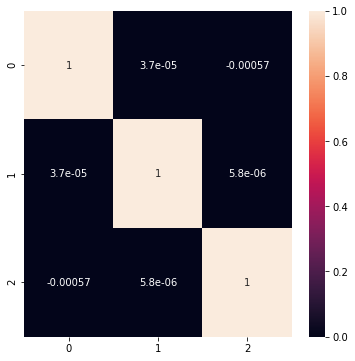

In [430]:
# Plotting a heatmap using the correlation matrix to check for correlation. Very low correlation is expected at this stage.
plt.figure(figsize=[6,6])
sns.heatmap(corrmat, annot=True)

#### From above correlation plot it can be observed that correlations are very close to 0. Hence there is no correlation between any two components which tells that PCA technique has been applied well to the data. We have effectively removed multicollinearity from our situation, and our models will be much more stable.

In [431]:
#Converting the PCA array to a dataframe
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca.head()

,PC1,PC2,PC3
0,-2.750999,1.209466,-0.498169
1,0.113886,-1.574902,0.010300
2,-0.262678,-0.822282,0.995621
3,-2.561408,2.066639,0.643336
4,1.507333,-0.664737,-0.231619


In [432]:
#Obtaining the list of countries from the original Dataframe
countries = list(df['country'])
df_country_name = pd.DataFrame(countries)
df_country_name.columns=['country']
df_country_name.head()

,country
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Antigua and Barbuda


In [433]:
# Adding the country column to the PCA dataframe
final_pca = pd.concat([df_country_name, df_pca], axis=1)
final_pca.head()

,country,PC1,PC2,PC3
0,Afghanistan,-2.750999,1.209466,-0.498169
1,Albania,0.113886,-1.574902,0.010300
2,Algeria,-0.262678,-0.822282,0.995621
3,Angola,-2.561408,2.066639,0.643336
4,Antigua and Barbuda,1.507333,-0.664737,-0.231619


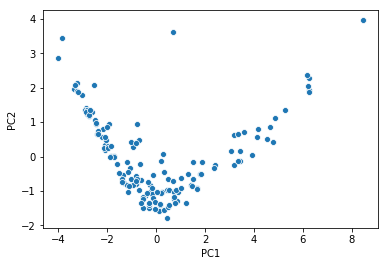

In [434]:
#Visualizing the the first two Principal Components using a scatterplot
sns.scatterplot(x='PC1',y='PC2',data=final_pca)

## 5.CLUSTERING

#### We will first check Hopkins Statistics to find if the dataset is suitable for clustering or not

Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [435]:
#Defining a function to check hopkins statistics
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [436]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(df_pca)

0.9316723723378169

#### On multiple iterations of the hopkins statistics function, we get a value between 0.8 to 0.95, thus we can proceed with clustering as the data has a high tendency to cluster.

### Finding optimal number of clusters

#### SSD

Text(0.5, 1.0, 'Elbow Curve')

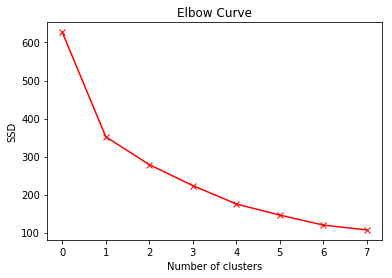

In [437]:
# We will plot a elbow-curve/SSD to decide the optimum value of K
ssd = []

for num_clusters in range(2,10):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_pca)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd,'rx-')
plt.xlabel("Number of clusters")
plt.ylabel("SSD")
plt.title("Elbow Curve")

#### From the Elbow curve we can say that k=3 seems like a good number of clusters. We will also check the Silhoutte score.

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$
$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [438]:
#We will also perform silhoutte score analysis to see if we can select an ideal number of clusters.

sse = []

for num_clusters in range(2,10):
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
        kmeans.fit(df_pca)
        cluster_labels = kmeans.labels_
        
        #silhouette score
        silhouette_avg = silhouette_score(df_pca, cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
        
        kmeans=KMeans(n_clusters=num_clusters).fit(df_pca)
        sse.append([num_clusters, silhouette_score(df_pca, kmeans.labels_)])
    

For n_clusters=2, the silhouette score is 0.549105573914539
For n_clusters=3, the silhouette score is 0.49237715244297325
For n_clusters=4, the silhouette score is 0.4943359670091511
For n_clusters=5, the silhouette score is 0.44112469797645304
For n_clusters=6, the silhouette score is 0.4007119311424395
For n_clusters=7, the silhouette score is 0.3664171131233145
For n_clusters=8, the silhouette score is 0.38783295617499663
For n_clusters=9, the silhouette score is 0.3829615149162787


Text(0, 0.5, 'Silhouette Score')

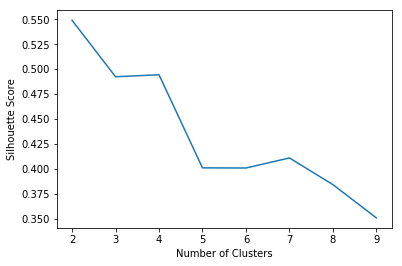

In [439]:
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1])
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

#### The Silhoutte Score is highest for k=2. Hence, we can proceed with clustering with either k=2 or k=3. We will perform two iterations to see which 'k' value gives us better clusters.

### Fitting K means on the data set

#### i. First iteration with k=2

In [440]:
#Applying K means clustering with K=2 on the data
kmeans2 = KMeans(n_clusters=2,random_state=42, max_iter=1000)
kmeans2.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [441]:
#Checking the cluster labels obtained for K=2
kmeans2.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [442]:
# assign the cluster labels
final_pca['cluster_id'] = kmeans2.labels_
final_pca.head()

,country,PC1,PC2,PC3,cluster_id
0,Afghanistan,-2.750999,1.209466,-0.498169,0
1,Albania,0.113886,-1.574902,0.010300,0
2,Algeria,-0.262678,-0.822282,0.995621,0
3,Angola,-2.561408,2.066639,0.643336,0
4,Antigua and Barbuda,1.507333,-0.664737,-0.231619,0


In [443]:
#Checking the number of countries alloted to each cluster for K=2
final_pca['cluster_id'].value_counts()

0    125
1     25
Name: cluster_id, dtype: int64

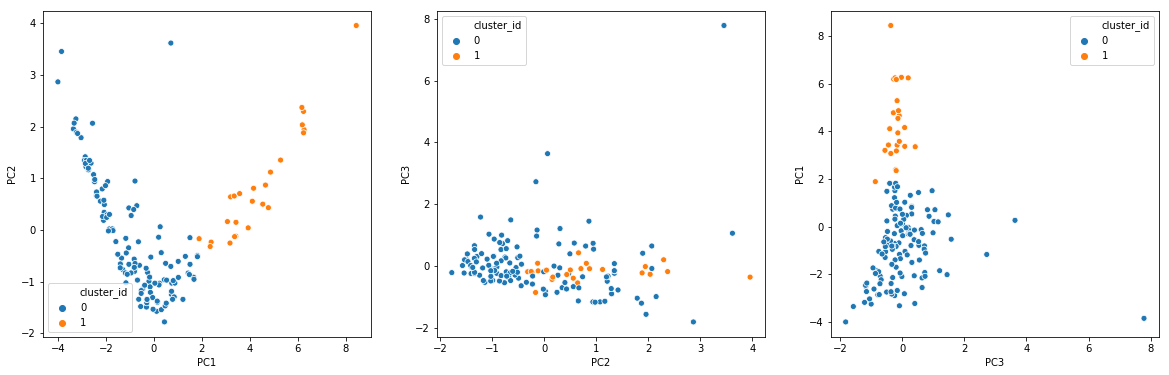

In [444]:
#Plotting Scatterplots to visualize the clusters formed for K=2
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.scatterplot(x='PC1',y='PC2',hue='cluster_id',legend='full',data=final_pca)

plt.subplot(1,3,2)
sns.scatterplot(x='PC2',y='PC3',hue='cluster_id',legend='full',data=final_pca)

plt.subplot(1,3,3)
sns.scatterplot(x='PC3',y='PC1',hue='cluster_id',legend='full',data=final_pca)


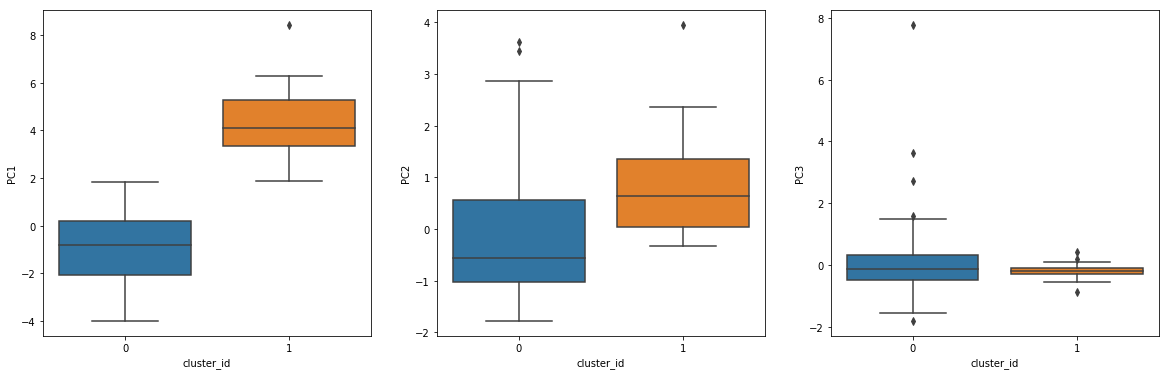

In [445]:
# plot box plots to visualize the clusters for K=2
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.boxplot(x='cluster_id', y='PC1', data=final_pca)

plt.subplot(1,3,2)
sns.boxplot(x='cluster_id', y='PC2', data=final_pca)

plt.subplot(1,3,3)
sns.boxplot(x='cluster_id', y='PC3', data=final_pca)

#### ii. Second iteration with k=3

In [446]:
#Applying K means clustering with K=3 on the data
kmeans3 = KMeans(n_clusters=3,random_state=42, max_iter=1000)
kmeans3.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [447]:
#Checking the cluster labels obtained when K=3
kmeans3.labels_

array([0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1,
       1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0])

In [448]:
# assign the cluster labels
final_pca1=final_pca.drop(["cluster_id"],axis=1)
final_pca1['cluster_id'] = kmeans3.labels_
final_pca1.head()

,country,PC1,PC2,PC3,cluster_id
0,Afghanistan,-2.750999,1.209466,-0.498169,0
1,Albania,0.113886,-1.574902,0.010300,1
2,Algeria,-0.262678,-0.822282,0.995621,1
3,Angola,-2.561408,2.066639,0.643336,0
4,Antigua and Barbuda,1.507333,-0.664737,-0.231619,1


In [449]:
#Checking the number of countries alloted to each cluster when K=3
final_pca1['cluster_id'].value_counts()

1    83
0    45
2    22
Name: cluster_id, dtype: int64

#### We can see that a good number of countries are alloted to each cluster. This spread of countries is better than that obtained at K=2. Also, we can go ahead with 3 clusters as if we look at the business aspect of it, we can categorize these 3 clusters as "Under-developed", "Developed", and "Very Well Developed". This way we will have one category with countries which are considerably under-developed compared to the others and this will help us in preparing the final list. 

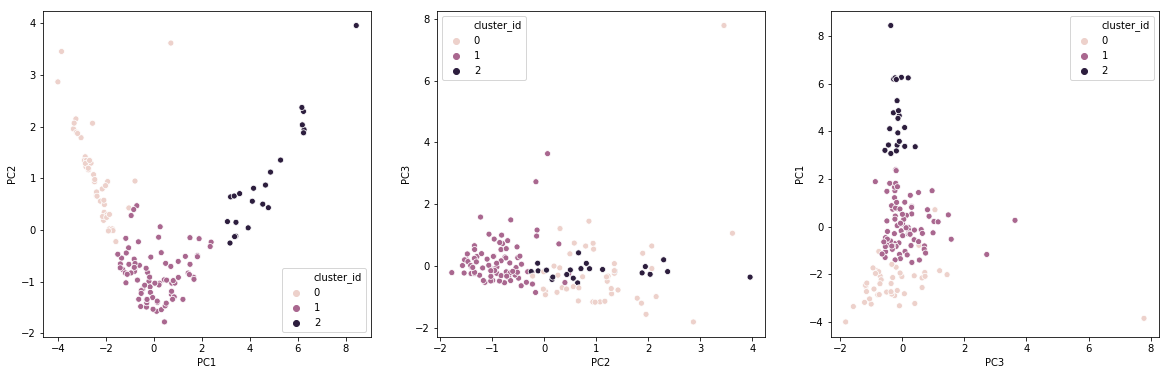

In [450]:
# plot Scatter plots to visualize the clusters for K=3
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.scatterplot(x='PC1',y='PC2',hue='cluster_id',legend='full',data=final_pca1)

plt.subplot(1,3,2)
sns.scatterplot(x='PC2',y='PC3',hue='cluster_id',legend='full',data=final_pca1)

plt.subplot(1,3,3)
sns.scatterplot(x='PC3',y='PC1',hue='cluster_id',legend='full',data=final_pca1)

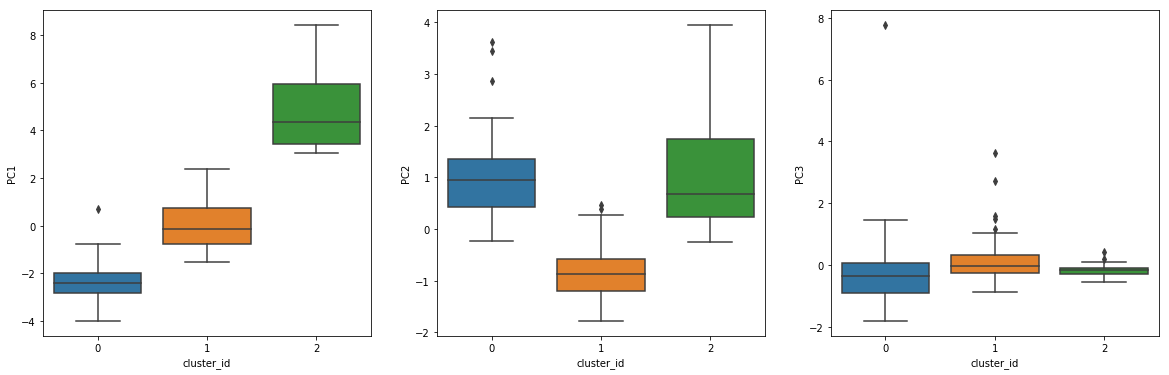

In [451]:
# plot box plots to visualize the clusters for K=3
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.boxplot(x='cluster_id', y='PC1', data=final_pca1)

plt.subplot(1,3,2)
sns.boxplot(x='cluster_id', y='PC2', data=final_pca1)

plt.subplot(1,3,3)
sns.boxplot(x='cluster_id', y='PC3', data=final_pca1)

#### From the above visuals of scatterplots and box plots, we could see that three clusters formed are distinct and clear. However, we will try Hierarchical Clustering to see if we get better results from that

### Hierarchical Clustering

In [452]:
df_pca.head()

,PC1,PC2,PC3
0,-2.750999,1.209466,-0.498169
1,0.113886,-1.574902,0.010300
2,-0.262678,-0.822282,0.995621
3,-2.561408,2.066639,0.643336
4,1.507333,-0.664737,-0.231619


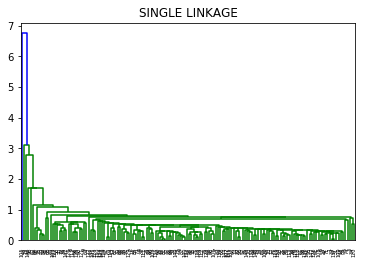

In [453]:
#First we'll try the single linkage procedure

mergings = linkage(df_pca, method = "single", metric='euclidean')
dendrogram(mergings)
plt.title("SINGLE LINKAGE")
plt.show()

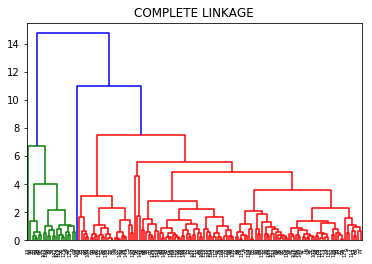

In [454]:
# complete linkage

mergings = linkage(df_pca, method="complete", metric='euclidean')
dendrogram(mergings)
plt.title("COMPLETE LINKAGE")
plt.show()

In [455]:
# 2 clusters
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [456]:
# assign cluster labels
grouped_df=final_pca.drop(["cluster_id"],axis=1)
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,country,PC1,PC2,PC3,cluster_labels
0,Afghanistan,-2.750999,1.209466,-0.498169,0
1,Albania,0.113886,-1.574902,0.010300,0
2,Algeria,-0.262678,-0.822282,0.995621,0
3,Angola,-2.561408,2.066639,0.643336,0
4,Antigua and Barbuda,1.507333,-0.664737,-0.231619,0


In [457]:
#checking the number of countries alloted to each cluster when we cut the dendrogram at 2 clusters.
grouped_df['cluster_labels'].value_counts()

0    128
1     22
Name: cluster_labels, dtype: int64

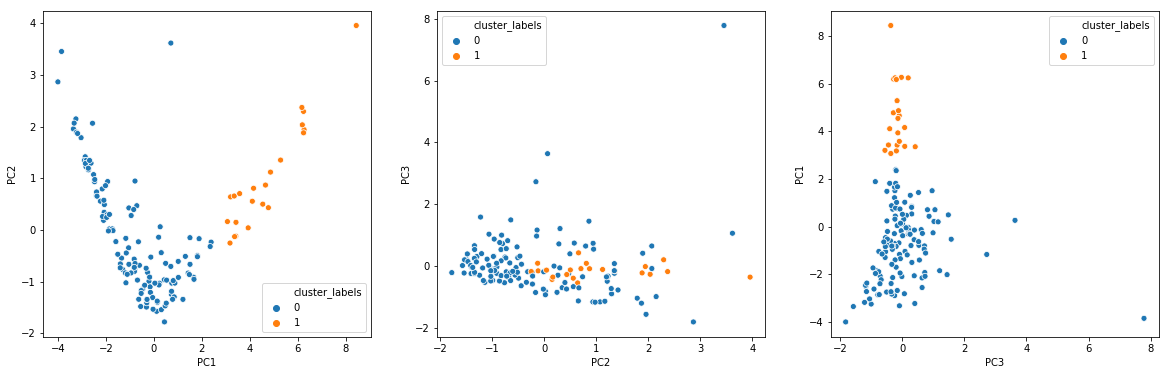

In [458]:
# plot scatter plots to visualize the clusters obtained from hierarchical clustering
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.scatterplot(x='PC1',y='PC2',hue='cluster_labels',legend='full',data=grouped_df)

plt.subplot(1,3,2)
sns.scatterplot(x='PC2',y='PC3',hue='cluster_labels',legend='full',data=grouped_df)

plt.subplot(1,3,3)
sns.scatterplot(x='PC3',y='PC1',hue='cluster_labels',legend='full',data=grouped_df)

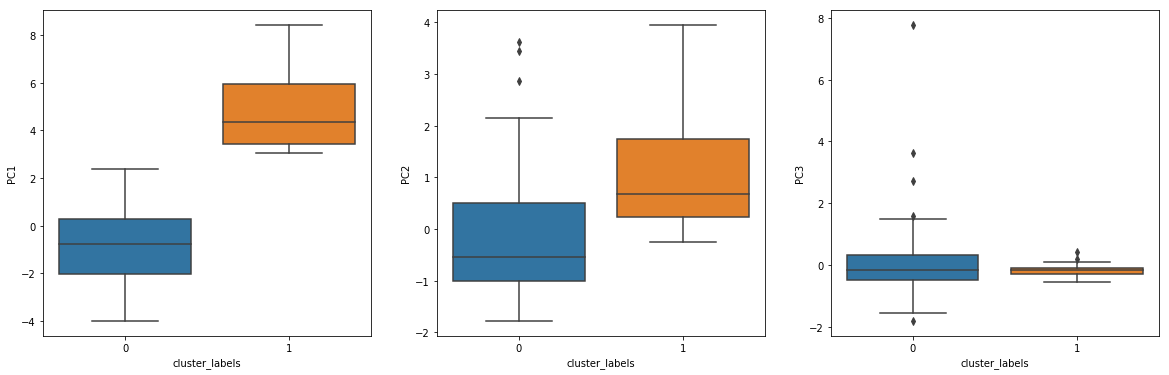

In [459]:
# plot box plots to visualize the clusters obtained from hierarchical clustering
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sns.boxplot(x='cluster_labels', y='PC1', data=grouped_df)

plt.subplot(1,3,2)
sns.boxplot(x='cluster_labels', y='PC2', data=grouped_df)

plt.subplot(1,3,3)
sns.boxplot(x='cluster_labels', y='PC3', data=grouped_df)

#### ANALYSING THE CLUSTERS

#### We performed both K-means clustering and Hierarchical Clustering. From the scatterplots and box plots, we can see that the hierarchical clustering gives very similar results to the k-means clustering when K=2. However, in order to get countries which require the most help we can perform the further analysis with 3 clusters such that we can label it as "Under-developed", "Developed" and "Very Well-Developed". This way the CEO can focus on the countries which are in a very bad shape and require funds.

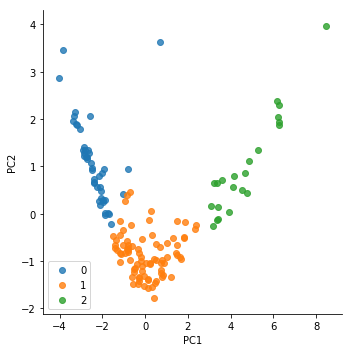

In [460]:
# now again visualizind spread of the data with the clusters obtained from K-means clustering with K=3
sns.lmplot(x='PC1', y='PC2', data=final_pca1, fit_reg=False, hue='cluster_id', legend=False)
plt.legend(loc='lower left')

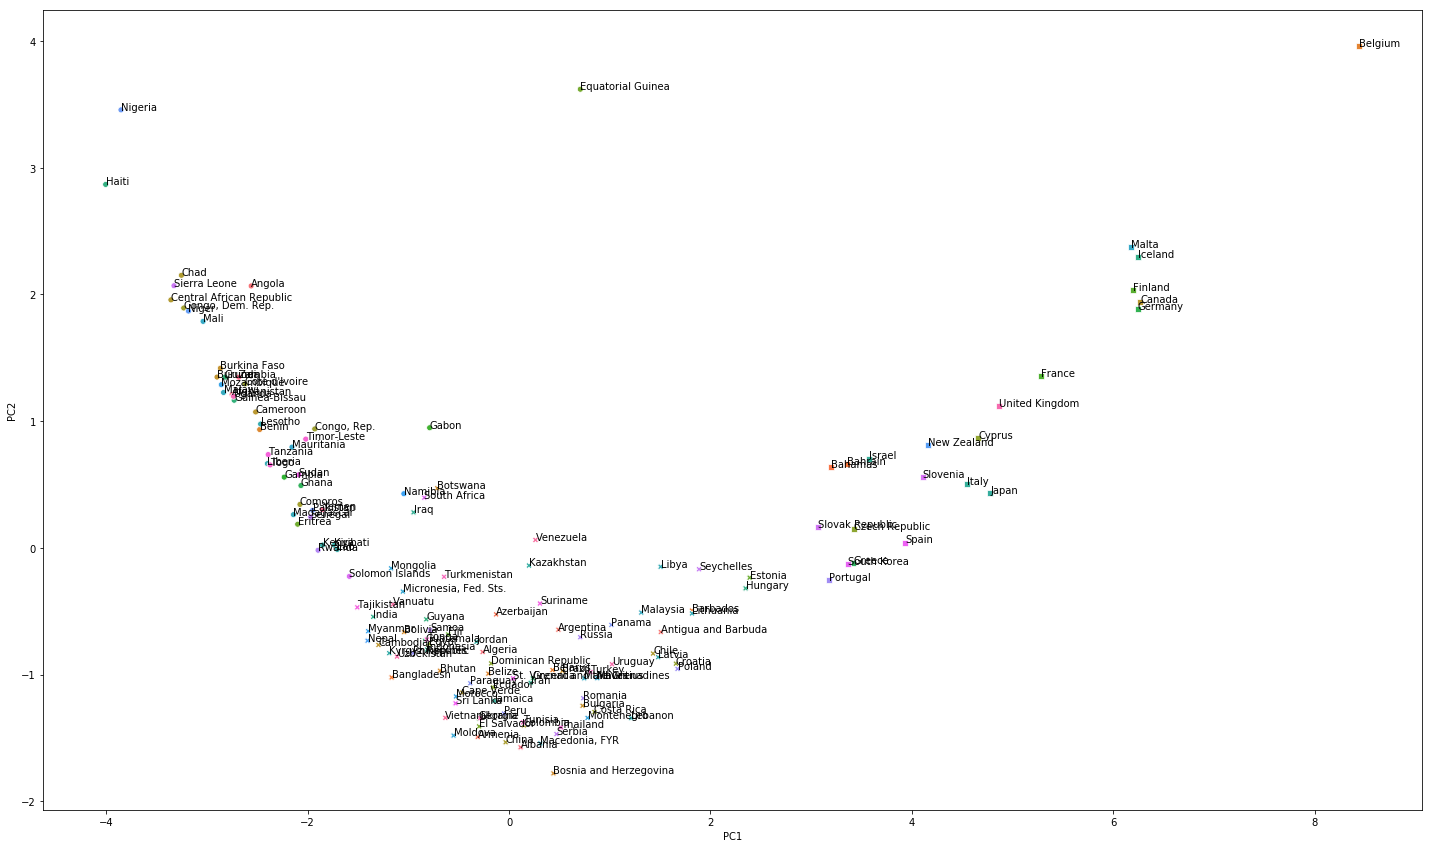

In [461]:
#plotting PC1 and PC2 with countries for the three clusters obtained from K-means clustering

fig = plt.figure(figsize = (20,25))

sns.scatterplot(x="PC1", y="PC2",style="cluster_id",hue='country',data=final_pca1)

plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(final_pca1.country):
    plt.annotate(txt, (final_pca1.PC1[i],final_pca1.PC2[i]))
plt.tight_layout()
plt.legend().set_visible(False)
plt.show()

In [462]:
#Create a dataframe with the original features and merging it with the cluster IDs obtained from K-means clustering for K=3
final_df = df.merge(final_pca1, on = 'country')
final_df=final_df.drop(["PC1","PC2","PC3"],axis=1)
final_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,1


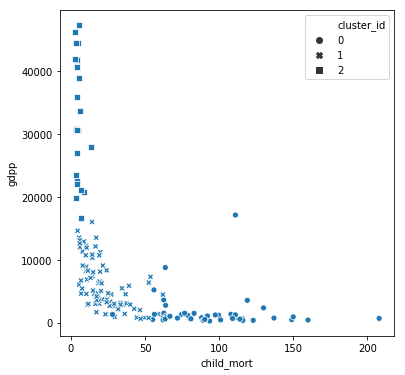

In [463]:
#Plotting a graph between child mortality and gdpp for the three clusters
fig = plt.figure(figsize = (6,6))

sns.scatterplot(x="child_mort", y="gdpp",style="cluster_id",data=final_df)

plt.xlabel('child_mort')
plt.ylabel('gdpp')
plt.show()

#### Inference: Cluster 0 countries are low in income and high in child mortality,it can be analysed from here

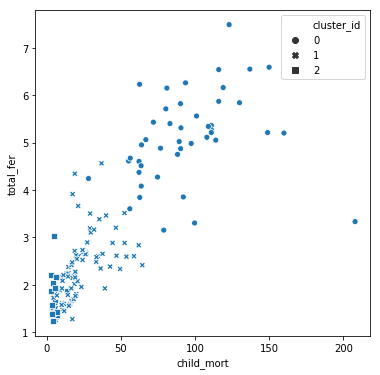

In [464]:
#Plotting a graph between child mortality and total fertility for the three clusters
fig = plt.figure(figsize = (6,6))

sns.scatterplot(x="child_mort", y="total_fer",style="cluster_id",data=final_df)

plt.xlabel('child_mort')
plt.ylabel('total_fer')
plt.show()

#### Inference: Cluster 0 countries have high total fertility and high rate of child mortality as well.

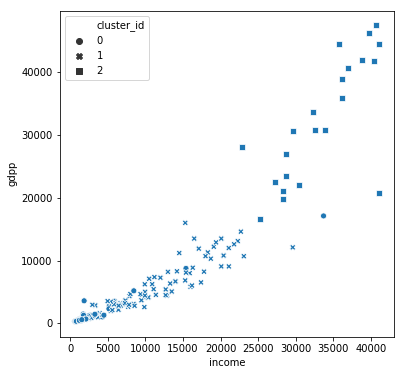

In [465]:
#Plotting a graph between income and gdpp for the three clusters
fig = plt.figure(figsize = (6,6))

sns.scatterplot(x="income", y="gdpp",style="cluster_id",data=final_df)

plt.xlabel('income')
plt.ylabel('gdpp')
plt.show()

#### Inference: We can see that cluster 0 consists of countries having very low income as well as gdpp.

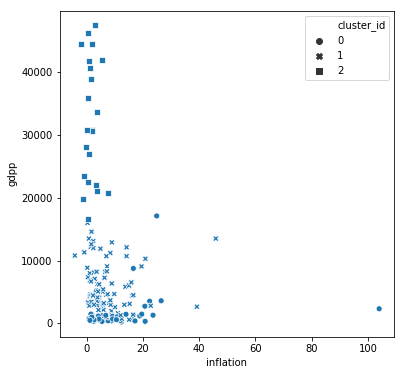

In [466]:
#Plotting a graph between gdpp and inflation for the three clusters
fig = plt.figure(figsize = (6,6))

sns.scatterplot(x="inflation", y="gdpp",style="cluster_id",data=final_df)

plt.xlabel('inflation')
plt.ylabel('gdpp')
plt.show()

#### Inference: We can see that cluster 0 has very low values for gdpp.

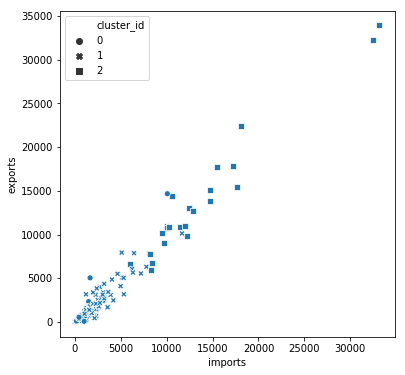

In [467]:
#Plotting a graph between exports and imports for the three clusters
fig = plt.figure(figsize = (6,6))

sns.scatterplot(x="imports", y="exports",style="cluster_id",data=final_df)

plt.xlabel('imports')
plt.ylabel('exports')
plt.show()

#### Inference: We can see that cluster 0 has very low values for both exports and imports.

In [468]:
#Calculating mean of each variable grouped by 'cluster_id'
df_child_mort = pd.DataFrame(final_df.groupby(["cluster_id"]).child_mort.mean())
df_exports = pd.DataFrame(final_df.groupby(["cluster_id"]).exports.mean())
df_health = pd.DataFrame(final_df.groupby(["cluster_id"]).health.mean())
df_imports = pd.DataFrame(final_df.groupby(["cluster_id"]).imports.mean())
df_income = pd.DataFrame(final_df.groupby(["cluster_id"]).income.mean())
df_inflation = pd.DataFrame(final_df.groupby(["cluster_id"]).inflation.mean())
df_life_expec = pd.DataFrame(final_df.groupby(["cluster_id"]).life_expec.mean())
df_total_fer = pd.DataFrame(final_df.groupby(["cluster_id"]).total_fer.mean())
df_gdpp = pd.DataFrame(final_df.groupby(["cluster_id"]).gdpp.mean())

In [469]:
#Creating a dataframe from the mean data
mean_df= pd.concat([pd.Series(list(range(0,3))), df_child_mort,df_exports, df_health, 
                        df_imports,df_income, df_inflation, df_life_expec,
                        df_total_fer,df_gdpp], axis=1)
mean_df.columns = ["clusterID", "child_mort_mean", "exports_mean", "health_mean", "imports_mean", "income_mean", 
                           "inflation_mean","life_expec_mean", "total_fer_mean", "gdpp_mean"]
mean_df

,clusterID,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,94.537778,790.474889,87.891778,731.346889,3312.733333,11.997000,59.220000,5.102000,1633.600000
1,1,23.080723,2567.253976,390.660723,2774.770964,11521.566265,7.603964,72.389157,2.312048,5965.084337
2,2,4.972727,14011.277273,3036.961818,13893.086364,33409.090909,1.520864,79.845455,1.715000,32200.000000


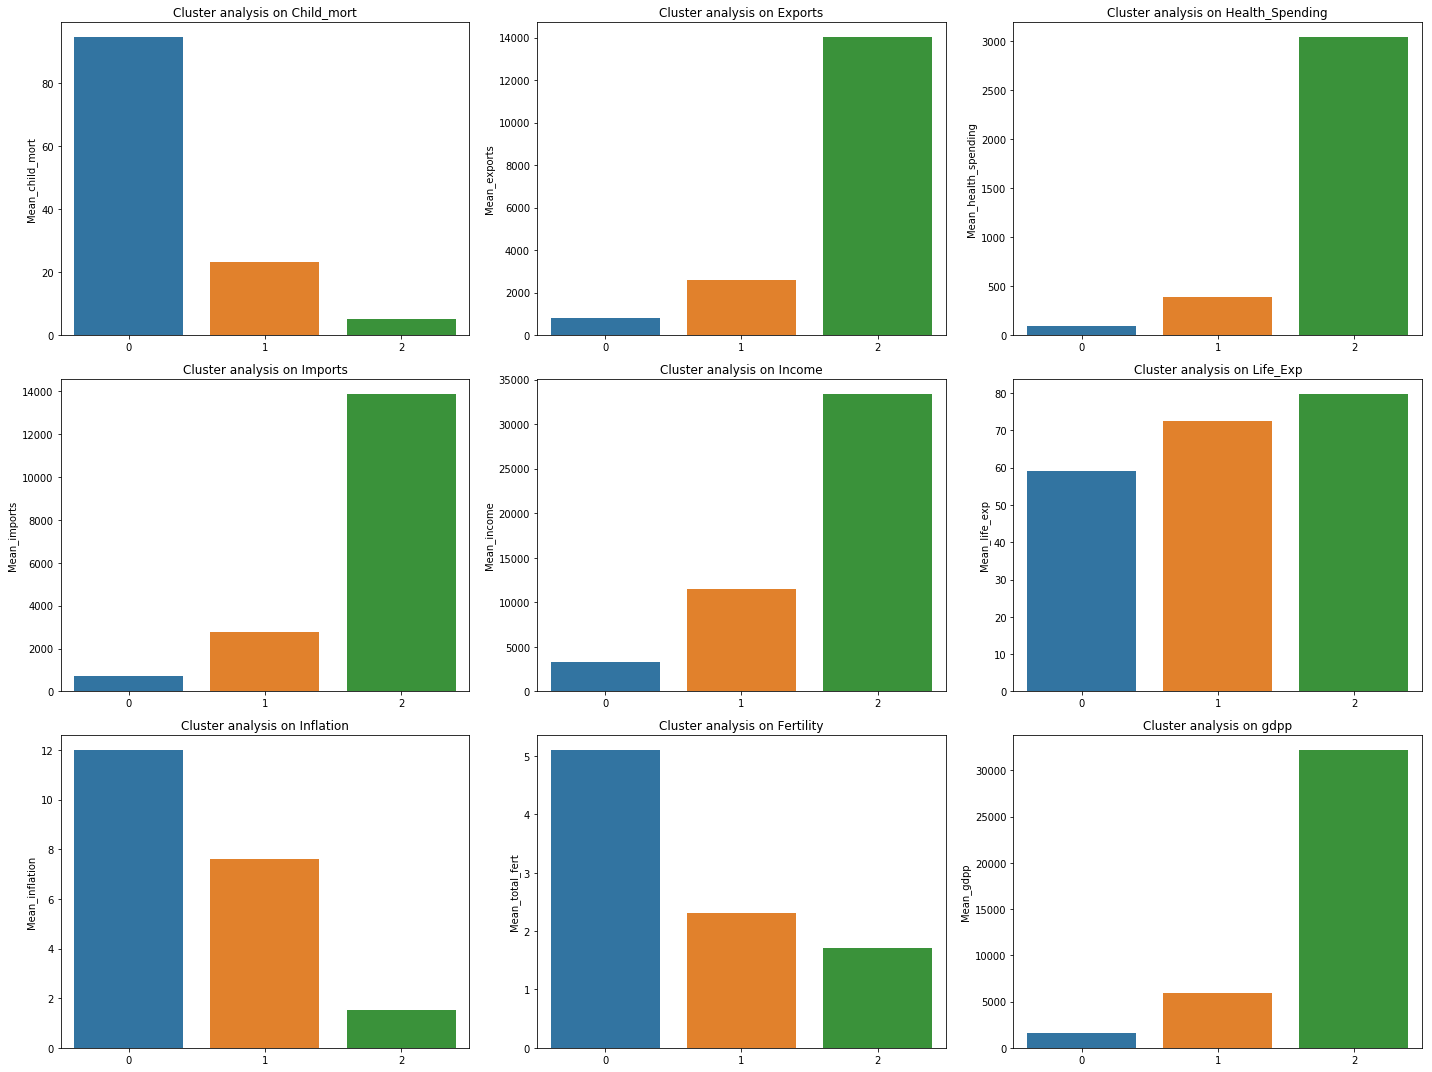

In [470]:
#plotting bar charts to visualize the spread of the three clusters and see which cluster represents the under-developed countries
fig, axs = plt.subplots(3,3,figsize = (20,15))

#Cluster analysis on Child_mort
plt1 = sns.barplot(x=mean_df.clusterID, y=mean_df.child_mort_mean, ax = axs[0,0])
plt1.set(title = 'Cluster analysis on Child_mort', xlabel = '', ylabel= 'Mean_child_mort')

#Cluster analysis on Exports
plt2 = sns.barplot(x=mean_df.clusterID, y=mean_df.exports_mean, ax = axs[0,1])
plt2.set(title = 'Cluster analysis on Exports', xlabel = '', ylabel= 'Mean_exports')

#Cluster analysis on Health_Spending
plt3 = sns.barplot(x=mean_df.clusterID, y=mean_df.health_mean, ax = axs[0,2])
plt3.set(title = 'Cluster analysis on Health_Spending', xlabel = '', ylabel= 'Mean_health_spending')

#Cluster analysis on Imports
plt4 = sns.barplot(x=mean_df.clusterID, y=mean_df.imports_mean, ax = axs[1,0])
plt4.set(title = 'Cluster analysis on Imports', xlabel = '', ylabel= 'Mean_imports')

#Cluster analysis on Income
plt5 = sns.barplot(x=mean_df.clusterID, y=mean_df.income_mean, ax = axs[1,1])
plt5.set(title = 'Cluster analysis on Income', xlabel = '', ylabel= 'Mean_income')

#Cluster analysis on Life_Exp
plt6 = sns.barplot(x=mean_df.clusterID, y=mean_df.life_expec_mean, ax = axs[1,2])
plt6.set(title = 'Cluster analysis on Life_Exp', xlabel = '', ylabel= 'Mean_life_exp')

#Cluster analysis on Inflation
plt7= sns.barplot(x=mean_df.clusterID, y=mean_df.inflation_mean, ax = axs[2,0])
plt7.set(title = 'Cluster analysis on Inflation', xlabel = '', ylabel= 'Mean_inflation')

#Cluster analysis on Fertility
plt8 = sns.barplot(x=mean_df.clusterID, y=mean_df.total_fer_mean, ax = axs[2,1])
plt8.set(title = 'Cluster analysis on Fertility', xlabel = '', ylabel= 'Mean_total_fert')

#Cluster analysis on gdpp
plt9 = sns.barplot(x=mean_df.clusterID, y=mean_df.gdpp_mean, ax = axs[2,2])
plt9.set(title = 'Cluster analysis on gdpp', xlabel = '', ylabel= 'Mean_gdpp')

plt.tight_layout()
plt.show()

In [471]:
#From above plots it is evident that custer 0 is the cluster which needs aid at the most. Let's find list of countries
final_df[final_df['cluster_id'] == 0].country.values

array(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire",
       'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao',
       'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda',
       'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tanzania',
       'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'], dtype=object)

#### Above is the list of underdeveloped countries which are need of aid at most.To find the Top 5 countries within cluster 1 we will consider 'child_mort', 'inflation', & 'total_fer' as factors to select top 5 countries as if the the countries which have high sum of these 3 columns can be considered as top 5.

In [472]:
plot_df=final_df.loc[final_df['cluster_id'] == 0]
plot_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.400,60.1,6.16,3530,0
15,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,0
22,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,0
23,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231,0


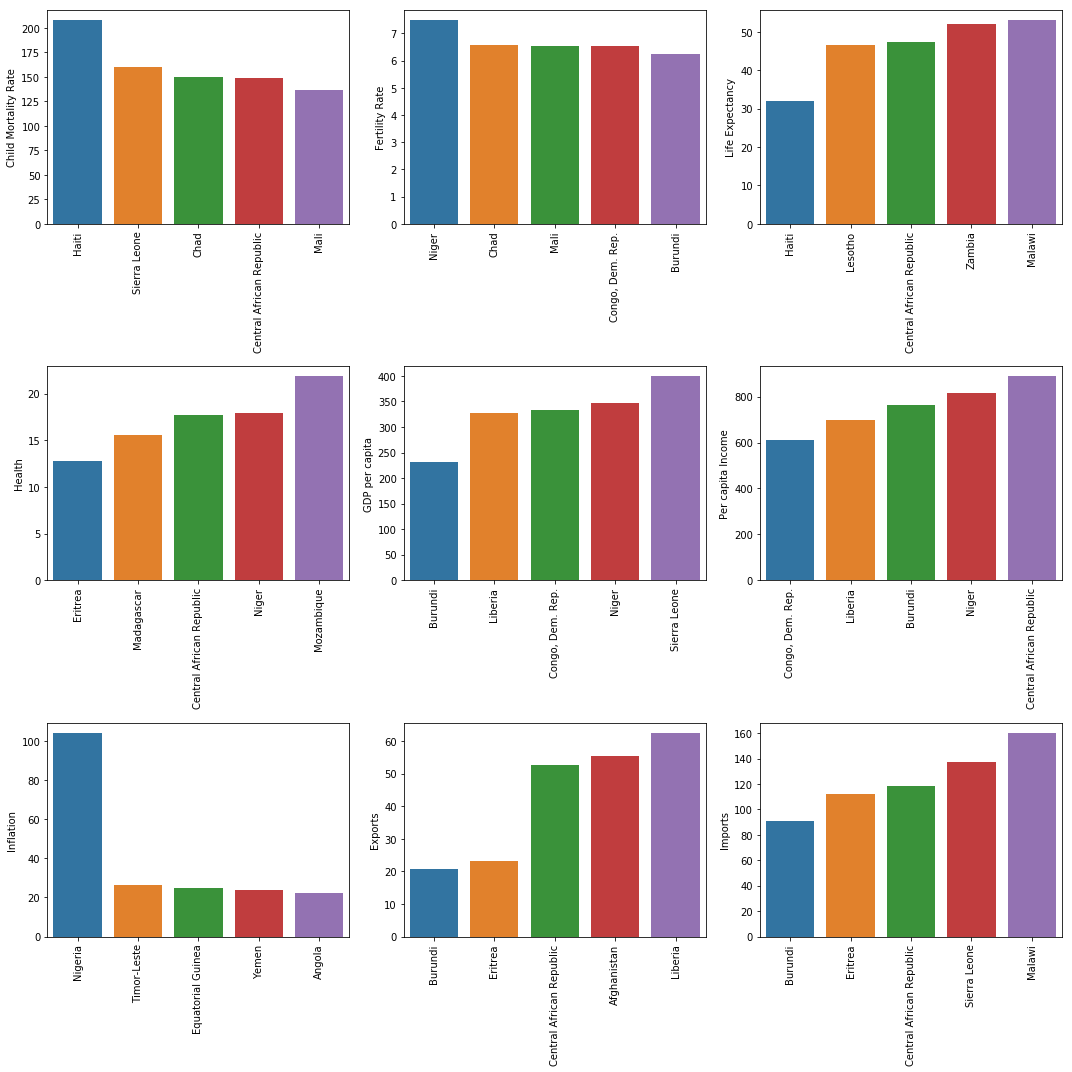

In [473]:
fig, axs = plt.subplots(3,3,figsize = (15,15))

# Child Mortality Rate : Death of children under 5 years of age per 1000 live births

top10_child_mort = plot_df[['country','child_mort']].sort_values('child_mort', ascending = False).head()
plt1 = sns.barplot(x='country', y='child_mort', data= top10_child_mort, ax = axs[0,0])
plt1.set(xlabel = '', ylabel= 'Child Mortality Rate')

# Fertility Rate: The number of children that would be born to each woman if the current age-fertility rates remain the same
top10_total_fer = plot_df[['country','total_fer']].sort_values('total_fer', ascending = False).head()
plt1 = sns.barplot(x='country', y='total_fer', data= top10_total_fer, ax = axs[0,1])
plt1.set(xlabel = '', ylabel= 'Fertility Rate')

# Life Expectancy: The average number of years a new born child would live if the current mortality patterns are to remain same

bottom10_life_expec = plot_df[['country','life_expec']].sort_values('life_expec', ascending = True).head()
plt1 = sns.barplot(x='country', y='life_expec', data= bottom10_life_expec, ax = axs[0,2])
plt1.set(xlabel = '', ylabel= 'Life Expectancy')

# Health :Total health spending as %age of Total GDP.

bottom10_health = plot_df[['country','health']].sort_values('health', ascending = True).head()
plt1 = sns.barplot(x='country', y='health', data= bottom10_health, ax = axs[1,0])
plt1.set(xlabel = '', ylabel= 'Health')

# The GDP per capita : Calculated as the Total GDP divided by the total population.

bottom10_gdpp = plot_df[['country','gdpp']].sort_values('gdpp', ascending = True).head()
plt1 = sns.barplot(x='country', y='gdpp', data= bottom10_gdpp, ax = axs[1,1])
plt1.set(xlabel = '', ylabel= 'GDP per capita')

# Per capita Income : Net income per person

bottom10_income = plot_df[['country','income']].sort_values('income', ascending = True).head()
plt1 = sns.barplot(x='country', y='income', data= bottom10_income, ax = axs[1,2])
plt1.set(xlabel = '', ylabel= 'Per capita Income')


# Inflation: The measurement of the annual growth rate of the Total GDP

top10_inflation = plot_df[['country','inflation']].sort_values('inflation', ascending = False).head()
plt1 = sns.barplot(x='country', y='inflation', data= top10_inflation, ax = axs[2,0])
plt1.set(xlabel = '', ylabel= 'Inflation')


# Exports: Exports of goods and services. Given as %age of the Total GDP

bottom10_exports = plot_df[['country','exports']].sort_values('exports', ascending = True).head()
plt1 = sns.barplot(x='country', y='exports', data= bottom10_exports, ax = axs[2,1])
plt1.set(xlabel = '', ylabel= 'Exports')


# Imports: Imports of goods and services. Given as %age of the Total GDP

bottom10_imports = plot_df[['country','imports']].sort_values('imports', ascending = True).head()
plt1 = sns.barplot(x='country', y='imports', data= bottom10_imports, ax = axs[2,2])
plt1.set(xlabel = '', ylabel= 'Imports')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.show()

#### From the above bar graphs, we can infer that:
1. Haiti, Sierra Leone have the highest number of child Mortalities.
2. Haiti is also the country with the least Life expectancy.
3. GDP per Capita, Exports and Imports are the lowest for Burundi.
4. Per Capita Income is lowest in congo. Dem. Rep.

#### To find the Top 5 countries within cluster 0 we can also consider 'child_mort', 'inflation', & 'total_fer' and look at their sum for each country. The country with the highest sum for these three columns will be one of the most under-developed.

In [474]:

plot_df['sum'] = plot_df['child_mort'] + plot_df['inflation'] + plot_df['total_fer']

plot_df = plot_df.sort_values(by='sum', ascending=False)
plot_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,sum
105,Nigeria,130.0,589.49,118.13,405.42,5150,104.00,60.5,5.84,2330,0,239.84
62,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662,0,216.78
120,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0,182.40
29,Chad,150.0,330.10,40.63,390.20,1930,6.39,56.5,6.59,897,0,162.98
28,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,0,156.22


#### From the above Analysis, we can say that the most under developed countries would be:

In [475]:
under_developed=list(plot_df.country)
print(under_developed)

['Nigeria', 'Haiti', 'Sierra Leone', 'Chad', 'Central African Republic', 'Mali', 'Angola', 'Congo, Dem. Rep.', 'Equatorial Guinea', 'Niger', 'Guinea', 'Burkina Faso', 'Guinea-Bissau', "Cote d'Ivoire", 'Mauritania', 'Benin', 'Cameroon', 'Mozambique', 'Burundi', 'Malawi', 'Lesotho', 'Pakistan', 'Afghanistan', 'Zambia', 'Sudan', 'Liberia', 'Uganda', 'Comoros', 'Togo', 'Ghana', 'Timor-Leste', 'Lao', 'Gambia', 'Congo, Rep.', 'Tanzania', 'Yemen', 'Gabon', 'Madagascar', 'Senegal', 'Eritrea', 'Rwanda', 'Kenya', 'Kiribati', 'Namibia', 'Solomon Islands']


#### Out of the above given 45 countries which fall under cluster 0 - under-developed countries, using the above visualizations and analysis - the top countries on which the CEO needs to focus on are:
1. Nigeria
2. Haiti
3. Sierra Leone
4. Chad
5. Central African Republic
6. Burundi
7. Eritrea

#### Some of the other countries that require attention are :​

1. Niger
2. Lesotho
3. Mali